In [5]:
!pip install torch torchvision matplotlib numpy scikit-learn


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import time

In [7]:
# Configuration des paramètres
BATCH_SIZE = 128
EPOCHS = 15
LEARNING_RATE = 0.001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Utilisation de: {DEVICE}")

Utilisation de: cpu


In [8]:
# Prétraitement et chargement des données
def load_cifar10():
    # Transformations pour les données d'entraînement (avec augmentation)
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    # Transformations pour les données de test (sans augmentation)
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    # Chargement des ensembles de données
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', 
        train=True, 
        download=True, 
        transform=transform_train
    )
    
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', 
        train=False, 
        download=True, 
        transform=transform_test
    )
    
    # Création des DataLoaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        num_workers=2
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        num_workers=2
    )
    
    # Classes dans CIFAR-10
    classes = ('avion', 'automobile', 'oiseau', 'chat', 'cerf', 
               'chien', 'grenouille', 'cheval', 'bateau', 'camion')
    
    return train_loader, test_loader, classes

CIFAR10CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc1_relu): ReLU(inplace=True)
  (dropout): Dropout(p=0.5, inplace=False)
  

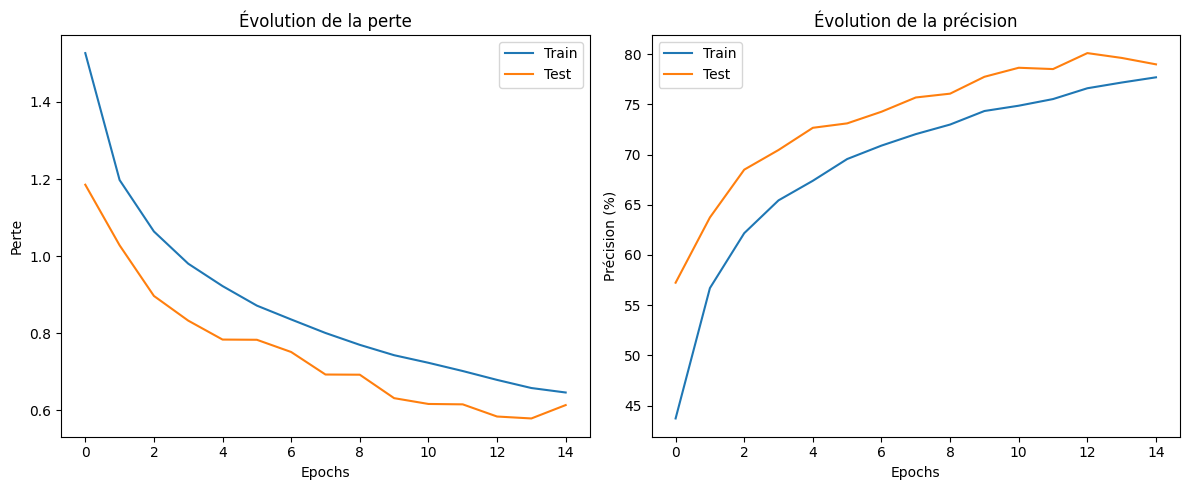


Évaluation finale du modèle:
Évaluation | Loss: 0.614 | Acc: 78.990%
Précision finale: 78.99%


In [9]:
# Définition de l'architecture CNN
class CIFAR10CNN(nn.Module):
    def __init__(self):
        super(CIFAR10CNN, self).__init__()
        # Bloc 1: Convolution + activation + pooling
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Bloc 2: Convolution + activation + pooling
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Bloc 3: Convolution + activation + pooling
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Couches fully connected
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc1_relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.5)  # Dropout pour éviter le surapprentissage
        self.fc2 = nn.Linear(512, 10)   # 10 classes pour CIFAR-10
        
    def forward(self, x):
        # Bloc 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        # Bloc 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # Bloc 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        # Aplatir les features pour les couches fully connected
        x = x.view(x.size(0), -1)
        
        # Couches fully connected
        x = self.fc1(x)
        x = self.fc1_relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Fonction d'entraînement
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Réinitialisation des gradients
        optimizer.zero_grad()
        
        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        # Statistiques
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Affichage de la progression
        if (batch_idx + 1) % 100 == 0:
            print(f'Batch: {batch_idx + 1}/{len(train_loader)} | '
                  f'Loss: {running_loss / (batch_idx + 1):.3f} | '
                  f'Acc: {100. * correct / total:.3f}%')
    
    return running_loss / len(train_loader), 100. * correct / total

# Fonction d'évaluation
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    accuracy = 100. * correct / total
    avg_loss = test_loss / len(test_loader)
    
    print(f'Évaluation | Loss: {avg_loss:.3f} | Acc: {accuracy:.3f}%')
    
    return avg_loss, accuracy

# Fonction pour visualiser les performances du modèle
def plot_performance(train_losses, train_accs, test_losses, test_accs):
    plt.figure(figsize=(12, 5))
    
    # Plot des pertes
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.title('Évolution de la perte')
    plt.xlabel('Epochs')
    plt.ylabel('Perte')
    plt.legend()
    
    # Plot des précisions
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train')
    plt.plot(test_accs, label='Test')
    plt.title('Évolution de la précision')
    plt.xlabel('Epochs')
    plt.ylabel('Précision (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('cifar10_cnn_performance.png')
    plt.show()

# Fonction principale
def main():
    # Chargement des données
    train_loader, test_loader, classes = load_cifar10()
    
    # Initialisation du modèle, de la fonction de perte et de l'optimiseur
    model = CIFAR10CNN().to(DEVICE)
    
    print(model)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Listes pour suivre les performances
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    
    # Boucle d'entraînement
    print(f"Début de l'entraînement sur {EPOCHS} epochs...")
    start_time = time.time()
    
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        
        # Entraînement
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, DEVICE)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Évaluation
        test_loss, test_acc = evaluate(model, test_loader, criterion, DEVICE)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
    
    total_time = time.time() - start_time
    print(f"\nTemps total d'entraînement: {total_time:.2f} secondes")
    
    # Sauvegarde du modèle
    torch.save(model.state_dict(), 'cifar10_cnn_model.pth')
    print("Modèle sauvegardé avec succès")
    
    # Visualisation des performances
    plot_performance(train_losses, train_accs, test_losses, test_accs)
    
    # Évaluation finale
    print("\nÉvaluation finale du modèle:")
    final_test_loss, final_test_acc = evaluate(model, test_loader, criterion, DEVICE)
    print(f"Précision finale: {final_test_acc:.2f}%")

if __name__ == "__main__":
    main()